Pairs trading, we need to test the cointegration and stationary of data

Import packages

In [110]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Stationary v.s. unstationary

/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_32119/3188099302.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  A = pd.Series(index = range(T))
/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_32119/3188099302.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  B = pd.Series(index = range(T))


Text(0.5, 1.0, 'Unstationary')

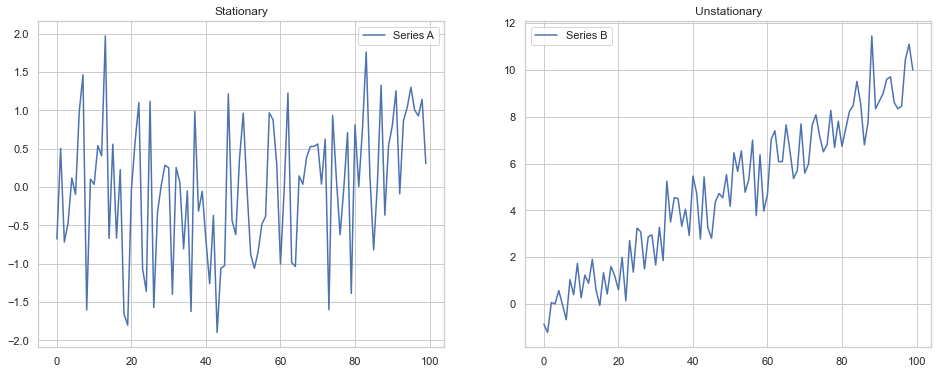

In [111]:
def generate_data(parameters):
    mu = parameters[0] ## the first item in parameters
    sigma = parameters[1] ## the second item in parameters
    return np.random.normal(mu, sigma)

parameters = (0, 1)
T = 100
A = pd.Series(index = range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(parameters) ## it will do T times

B = pd.Series(index = range(T))
B.name = 'B'

for t in range(T):
    parameters = (t*0.1, 1) ## the first item of parameter will increase by t, largest = 100 * 0.1 = 10
    B[t] = generate_data(parameters) ## it will do T times

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6)) ## plot two plots in one time
ax1.plot(A)
ax1.legend(['Series A'])
ax1.set_title('Stationary')
ax2.plot(B)
ax2.legend(['Series B'])
ax2.set_title('Unstationary')


Cointegration

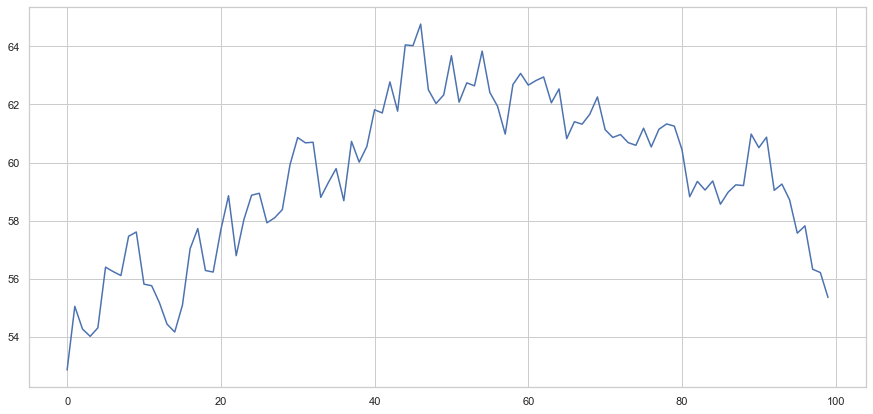

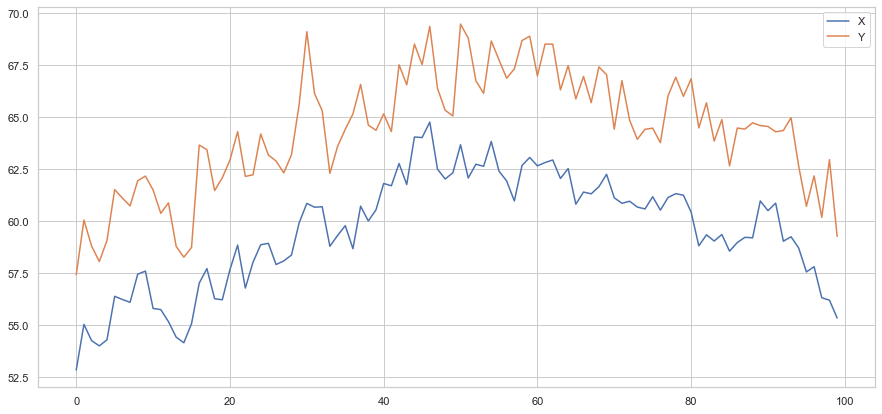

In [112]:
## Generate daily returns
Return = np.random.normal(0, 1, 100) ## define return as random normal sequence

## sum up and rise the daily return
X = pd.Series(np.cumsum(Return), name = 'X') + 50
X.plot(figsize = (15, 7))

noise = np.random.normal(0, 1, 100) ## define noise as random normal sequence
Y = X + noise + 5
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(15, 7)) ## pd.concat is for merging datas

plt.show()


Plot the price spread (price difference between A and B)

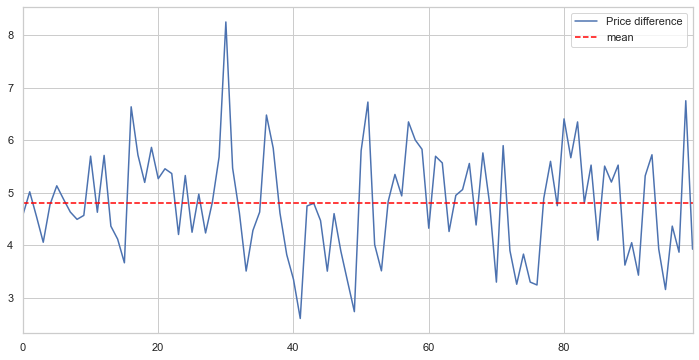

In [113]:
plt.figure(figsize = (12, 6))
(Y - X).plot()
plt.axhline((np.mean(Y - X)), color = 'red', linestyle = '--')
plt.xlabel = 'time'
plt.ylabel = 'price difference'
plt.xlim(0, 99)
plt.legend(['Price difference', 'mean'])

Determine cointegration

In [114]:
score, pvalue, _=coint(X, Y)
print(pvalue) ## small enough, cointegration

2.3708119194419295e-08


Import finance package

In [115]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

Start getting data and working on them

In [116]:
def find_cointegrated_pairs(data):
    n = data.shape[1] ## number of columns of data
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [117]:
import tqdm
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2022, 7, 1)
for i in tqdm.tqdm(range(100)):
    tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

data = pdr.get_data_yahoo(tickers, start, end)['Close']
data.tail()
print(data.iloc[1106])

100%|██████████| 100/100 [00:00<00:00, 719434.65it/s]


[*********************100%***********************]  11 of 11 completed
AAPL    126.849998
ADBE    506.980011
AMD      78.339996
EBAY     61.439999
HPQ      32.169998
IBM     137.074570
JNPR     26.570000
MSFT    251.490005
ORCL     79.260002
QCOM    133.089996
SPY     419.070007
Name: 2021-05-26 00:00:00, dtype: float64


[('AAPL', 'AMD'), ('AAPL', 'QCOM'), ('AMD', 'MSFT'), ('AMD', 'QCOM'), ('IBM', 'JNPR'), ('IBM', 'MSFT'), ('IBM', 'ORCL'), ('IBM', 'QCOM'), ('IBM', 'SPY'), ('ORCL', 'SPY'), ('QCOM', 'SPY')]


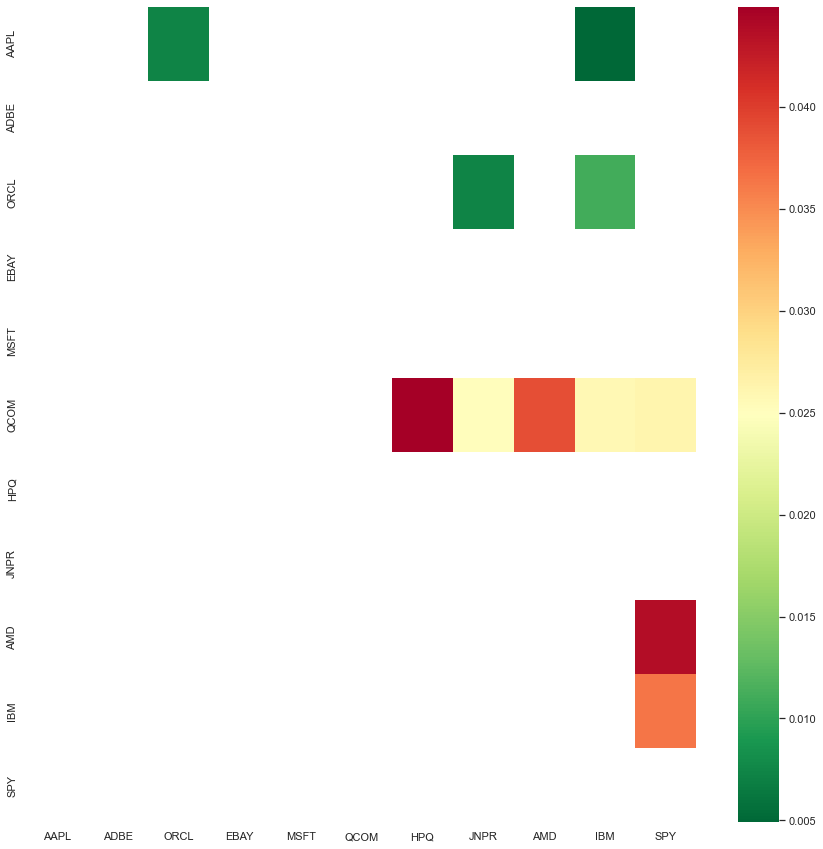

In [34]:
## plotting heatmap from seaborn
scores, pvalue, pairs = find_cointegrated_pairs(data)
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(pvalue, xticklabels=tickers, yticklabels=tickers, cmap = 'RdYlGn_r', mask = (pvalue >= 0.05))
print(pairs)

The solution is that AAPL/AMD, AAPL/QCOM, AMD/MSFT are the most significant cointegration pairs

In [62]:
## checking pvalue of the pair
S1 = data['AAPL']
S2 = data['QCOM']

scores, pvalue,_=coint(S1, S2)
pvalue

0.00490184121005248

            const        AAPL
Date                         
2017-01-03    1.0   29.037500
2017-01-04    1.0   29.004999
2017-01-05    1.0   29.152500
2017-01-06    1.0   29.477501
2017-01-09    1.0   29.747499
2017-01-10    1.0   29.777500
2017-01-11    1.0   29.937500
2017-01-12    1.0   29.812500
2017-01-13    1.0   29.760000
2017-01-17    1.0   30.000000
2017-01-18    1.0   29.997499
2017-01-19    1.0   29.945000
2017-01-20    1.0   30.000000
2017-01-23    1.0   30.020000
2017-01-24    1.0   29.992500
2017-01-25    1.0   30.469999
2017-01-26    1.0   30.485001
2017-01-27    1.0   30.487499
2017-01-30    1.0   30.407499
2017-01-31    1.0   30.337500
2017-02-01    1.0   32.187500
2017-02-02    1.0   32.132500
2017-02-03    1.0   32.270000
2017-02-06    1.0   32.572498
2017-02-07    1.0   32.882500
2017-02-08    1.0   33.009998
2017-02-09    1.0   33.105000
2017-02-10    1.0   33.029999
2017-02-13    1.0   33.322498
2017-02-14    1.0   33.755001
2017-02-15    1.0   33.877499
2017-02-16

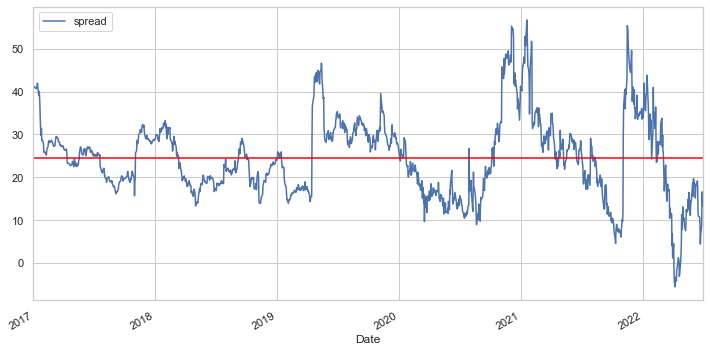

In [118]:
## calculating the spread
S1 = sm.add_constant(S1) ## for linear regression
print(S1)
result = sm.OLS(S2, S1).fit() ## S2 as Y and S1 as X
S1 = S1['AAPL']
beta = result.params['AAPL'] ## result.params is a method
print(beta)

spread = S2 - beta * S1
spread.plot(figsize = (12, 6))
plt.axhline(spread.mean(), color = 'red')
plt.xlim('2017-01-01', '2022-07-01')
plt.legend(["spread"])

Date
2017-01-03    0.443998
2017-01-04    0.443027
2017-01-05    0.444737
2017-01-06    0.449832
2017-01-09    0.453123
2017-01-10    0.453718
2017-01-11    0.452912
2017-01-12    0.450885
2017-01-13    0.444976
2017-01-17    0.467362
2017-01-18    0.460579
2017-01-19    0.464696
2017-01-20    0.477099
2017-01-23    0.547012
2017-01-24    0.545318
2017-01-25    0.535501
2017-01-26    0.564015
2017-01-27    0.562085
2017-01-30    0.567198
2017-01-31    0.567799
2017-02-01    0.605597
2017-02-02    0.610188
2017-02-03    0.609098
2017-02-06    0.615970
2017-02-07    0.617280
2017-02-08    0.624126
2017-02-09    0.626040
2017-02-10    0.611667
2017-02-13    0.606636
2017-02-14    0.608417
2017-02-15    0.599708
2017-02-16    0.594893
2017-02-17    0.600956
2017-02-21    0.602203
2017-02-22    0.600306
2017-02-23    0.597349
2017-02-24    0.597081
2017-02-27    0.603428
2017-02-28    0.606365
2017-03-01    0.613006
2017-03-02    0.616285
2017-03-03    0.619153
2017-03-06    0.617095
2017-0

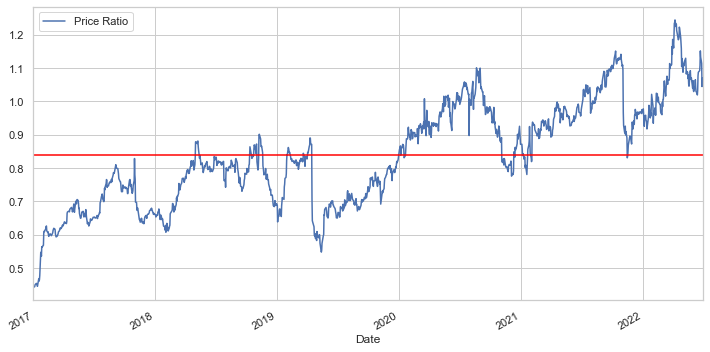

In [119]:
## ratio between two time series data
ratio = S1 / S2
print(ratio)
ratio.plot(figsize = (12, 6))
plt.axhline(ratio.mean(), color = 'red')
plt.xlim('2017-01-01', '2022-07-01')
plt.legend(['Price Ratio'])

Date
2017-01-03   -2.566753
2017-01-04   -2.573074
2017-01-05   -2.561947
2017-01-06   -2.528783
2017-01-09   -2.507366
2017-01-10   -2.503492
2017-01-11   -2.508735
2017-01-12   -2.521932
2017-01-13   -2.560390
2017-01-17   -2.414681
2017-01-18   -2.458835
2017-01-19   -2.432038
2017-01-20   -2.351307
2017-01-23   -1.896261
2017-01-24   -1.907284
2017-01-25   -1.971183
2017-01-26   -1.785591
2017-01-27   -1.798151
2017-01-30   -1.764871
2017-01-31   -1.760961
2017-02-01   -1.514939
2017-02-02   -1.485059
2017-02-03   -1.492155
2017-02-06   -1.447425
2017-02-07   -1.438900
2017-02-08   -1.394343
2017-02-09   -1.381881
2017-02-10   -1.475435
2017-02-13   -1.508181
2017-02-14   -1.496583
2017-02-15   -1.553272
2017-02-16   -1.584613
2017-02-17   -1.545146
2017-02-21   -1.537034
2017-02-22   -1.549376
2017-02-23   -1.568628
2017-02-24   -1.570367
2017-02-27   -1.529056
2017-02-28   -1.509942
2017-03-01   -1.466714
2017-03-02   -1.445373
2017-03-03   -1.426707
2017-03-06   -1.440105
2017-0

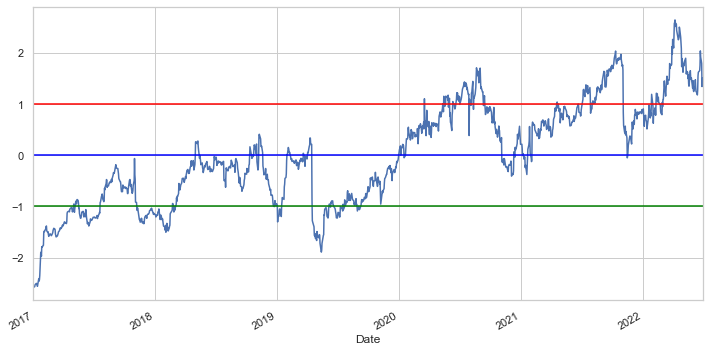

In [121]:
## standarlization
def z_score(series):
    return (series - series.mean()) / series.std()

z_score(ratio).plot(figsize = (12, 6))
plt.axhline(z_score(ratio).mean(), color = 'blue')
plt.axhline(1.0, color = 'red')
plt.axhline(-1.0, color = 'green')
plt.xlim('2017-01-01', '2022-07-01')
print(z_score(ratio))

In [120]:
## trading signals and data splitting(train, test)
print(len(ratio)*0.8)
train_dataset = ratio[:1106]
test_dataste = ratio[1106:]
print(train_dataset)

1106.4
Date
2017-01-03    0.443998
2017-01-04    0.443027
2017-01-05    0.444737
2017-01-06    0.449832
2017-01-09    0.453123
2017-01-10    0.453718
2017-01-11    0.452912
2017-01-12    0.450885
2017-01-13    0.444976
2017-01-17    0.467362
2017-01-18    0.460579
2017-01-19    0.464696
2017-01-20    0.477099
2017-01-23    0.547012
2017-01-24    0.545318
2017-01-25    0.535501
2017-01-26    0.564015
2017-01-27    0.562085
2017-01-30    0.567198
2017-01-31    0.567799
2017-02-01    0.605597
2017-02-02    0.610188
2017-02-03    0.609098
2017-02-06    0.615970
2017-02-07    0.617280
2017-02-08    0.624126
2017-02-09    0.626040
2017-02-10    0.611667
2017-02-13    0.606636
2017-02-14    0.608417
2017-02-15    0.599708
2017-02-16    0.594893
2017-02-17    0.600956
2017-02-21    0.602203
2017-02-22    0.600306
2017-02-23    0.597349
2017-02-24    0.597081
2017-02-27    0.603428
2017-02-28    0.606365
2017-03-01    0.613006
2017-03-02    0.616285
2017-03-03    0.619153
2017-03-06    0.617095

0.7227334029615865


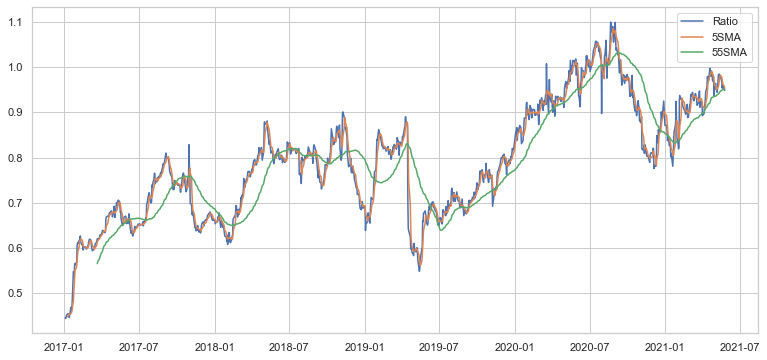

In [97]:
## Feature engineering
ratio_5SMA = train_dataset.rolling(5).mean()
ratio_55SMA = train_dataset.rolling(55).mean()
std_55 = train_dataset.rolling(55).std()
z_score_60_5 = (ratio_5SMA - ratio_55SMA) / std_55
print(z_score_60_5[54])
plt.figure(figsize = (13, 6))
plt.plot(train_dataset.index, train_dataset.values)
plt.plot(ratio_5SMA.index, ratio_5SMA.values)
plt.plot(ratio_55SMA.index, ratio_55SMA.values)
plt.legend(['Ratio', '5SMA', '55SMA'])


Date
2017-01-03    0.443998
2017-01-04    0.443027
2017-01-05    0.444737
2017-01-06    0.449832
2017-01-09    0.453123
                ...   
2021-05-19    0.954309
2021-05-20    0.959816
2021-05-21    0.954130
2021-05-24    0.956286
2021-05-25    0.948785
Length: 1106, dtype: float64


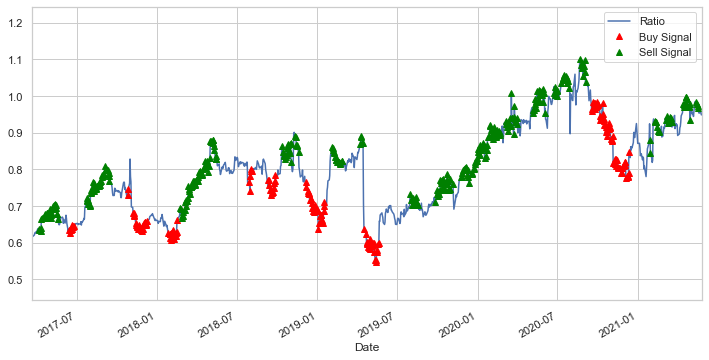

In [108]:
plt.figure(figsize = (12, 6))

train_dataset[54:].plot()
buy = train_dataset.copy()
sell = train_dataset.copy()
buy[z_score_60_5 > -1] = 0
sell[z_score_60_5 < 1] = 0
buy[54:].plot(color = 'red', linestyle = 'None', marker = '^')
sell[54:].plot(color = 'green', linestyle = 'None', marker = '^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.xlim('2017-03-22', '2021-05-26')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])



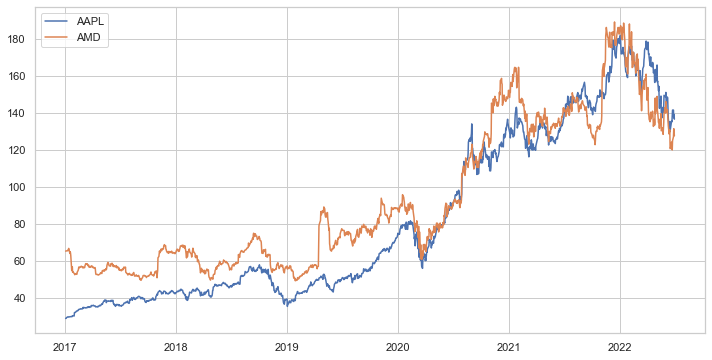

In [74]:
from matplotlib.pyplot import figure
train_AAPL = data['AAPL'][:1106]
train_QCOM = data['QCOM'][:1106]


plt.figure(figsize = (12, 6))
plt.plot(data['AAPL'])
plt.plot(data['QCOM'])
plt.legend(['AAPL', 'AMD'])